In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

<h1> Exploratory Data Analysis </h1>

<h2> Data Loading and Cleaning </h2>

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 100000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        print(df.head())
        break
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [3]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Train.db not found")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:04.696053


<h3> Checking for duplicates </h3>

In [4]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Train.db file not found")

Time taken to run this cell : 0:06:57.715288


In [5]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [13]:
print("number of duplicate questions: ", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",round((1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,2),"%)")

number of duplicate questions:  1827888 ( 30.29 %)


In [14]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656278
2    1272335
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [7]:
df_no_dup.drop(df_no_dup[df_no_dup['Tags'].isnull()].index, inplace=True)

#df.drop(df[df['Age'] < 25].index, inplace = True)

print(df_no_dup[df_no_dup['Tags'].isnull()])

Empty DataFrame
Columns: [Title, Body, Tags, cnt_dup]
Index: []


<h3> Adding a new feature number of tags per question </h3>

In [8]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:06.448547


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [15]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

<h3> Create New database with no duplicates </h3>

In [11]:
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [16]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:25.465793


## Analysis of Tags

### Total number of unique tags

In [18]:
#'split()' will tokenize each tag.

vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() fits the model and learns the vocabulary; also it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [19]:
print("# data points: ", tag_dtm.shape[0])
print("# unique tags: ", tag_dtm.shape[1])

# data points:  4206307
# unique tags:  42048


In [21]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Tag examples:", tags[:10])

Tag examples: ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### Number of times a tag appeared 

In [22]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [23]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [24]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

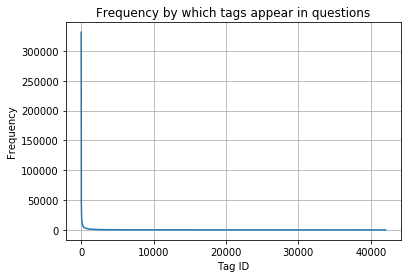

In [26]:
plt.plot(tag_counts)
plt.title("Frequency by which tags appear in questions")
plt.grid()
plt.xlabel("Tag ID")
plt.ylabel("Frequency")
plt.show()

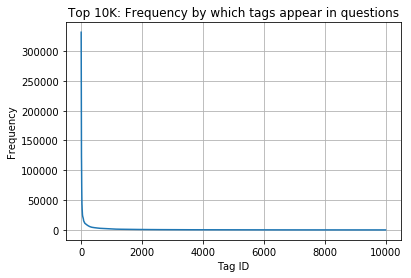

500 [331505  62023  26925  20957  15533  13364  11228  10350   9719   9040
   8054   7274   6656   6183   5760   5370   5066   4658   4429   4239
   4144   3957   3818   3685   3564   3453   3326   3196   3073   2983
   2891   2754   2681   2604   2510   2431   2363   2290   2222   2162
   2097   2036   1971   1940   1879   1828   1782   1741   1697   1665
   1631   1585   1551   1507   1472   1448   1412   1378   1349   1320
   1300   1272   1253   1233   1219   1197   1186   1172   1153   1136
   1121   1108   1085   1072   1053   1038   1029   1014    998    981
    966    955    944    932    922    911    896    885    877    868
    856    843    835    825    814    804    792    783    776    767
    752    745    737    730    721    712    703    692    685    676
    671    661    653    646    641    634    628    621    613    605
    598    590    584    581    575    568    560    554    549    544
    540    534    528    523    517    512    507    503    497    494
  

In [29]:
plt.plot(tag_counts[0:10000])
plt.title('Top 10K: Frequency by which tags appear in questions')
plt.grid()
plt.xlabel("Tag ID")
plt.ylabel("Frequency")
plt.show()
print(len(tag_counts[0:10000:20]), tag_counts[0:10000:20])

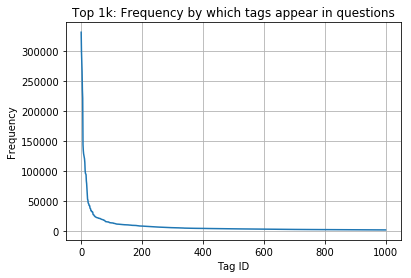

100 [331505 122769  62023  37170  26925  22429  20957  18905  15533  14884
  13364  12407  11228  10863  10350  10029   9719   9252   9040   8361
   8054   7702   7274   7052   6656   6466   6183   5971   5760   5490
   5370   5207   5066   4891   4658   4526   4429   4310   4239   4195
   4144   4050   3957   3874   3818   3750   3685   3615   3564   3505
   3453   3396   3326   3272   3196   3123   3073   3012   2983   2934
   2891   2819   2754   2726   2681   2647   2604   2556   2510   2460
   2431   2395   2363   2312   2290   2259   2222   2198   2162   2132
   2097   2057   2036   2011   1971   1959   1940   1912   1879   1855
   1828   1813   1782   1760   1741   1723   1697   1683   1665   1646]


In [30]:
plt.plot(tag_counts[0:1000])
plt.title('Top 1k: Frequency by which tags appear in questions')
plt.grid()
plt.xlabel("Tag ID")
plt.ylabel("Frequency")
plt.show()
print(len(tag_counts[0:1000:10]), tag_counts[0:1000:10])

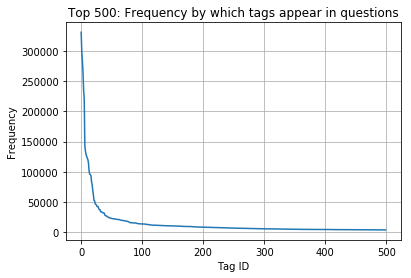

50 [331505 122769  62023  37170  26925  22429  20957  18905  15533  14884
  13364  12407  11228  10863  10350  10029   9719   9252   9040   8361
   8054   7702   7274   7052   6656   6466   6183   5971   5760   5490
   5370   5207   5066   4891   4658   4526   4429   4310   4239   4195
   4144   4050   3957   3874   3818   3750   3685   3615   3564   3505]


In [31]:
plt.plot(tag_counts[0:500])
plt.title('Top 500: Frequency by which tags appear in questions')
plt.grid()
plt.xlabel("Tag ID")
plt.ylabel("Frequency")
plt.show()
print(len(tag_counts[0:500:10]), tag_counts[0:500:10])

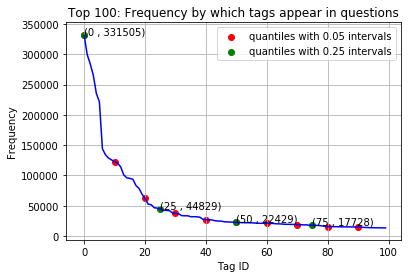

10 [331505 122769  62023  37170  26925  22429  20957  18905  15533  14884]


In [32]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,10)), y=tag_counts[0:100:10], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='green', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('Top 100: Frequency by which tags appear in questions')
plt.grid()
plt.xlabel("Tag ID")
plt.ylabel("Frequency")
plt.legend()
plt.show()
print(len(tag_counts[0:100:10]), tag_counts[0:100:10])

In [35]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('Tags occuring more than 10K times: {}'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('Tags occuring more than 100K times: {}'.format(len(lst_tags_gt_100k)))

Tags occuring more than 10K times: 153
Tags occuring more than 100K times: 14


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> Tags Per Question </h3>

In [37]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206307 datapoints.
[3, 4, 2, 2, 3]


In [43]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Average number of tags per question: %f"% round((sum(tag_quest_count)*1.0)/len(tag_quest_count),2))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Average number of tags per question: 2.900000


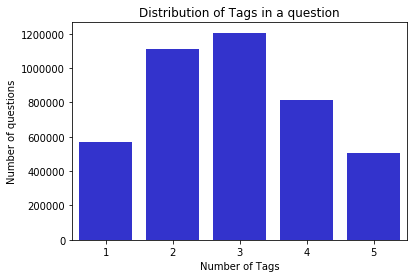

In [51]:
sns.countplot(tag_quest_count, color="blue", saturation=0.6)
plt.title("Distribution of Tags in a question")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

### Most Frequent Tags

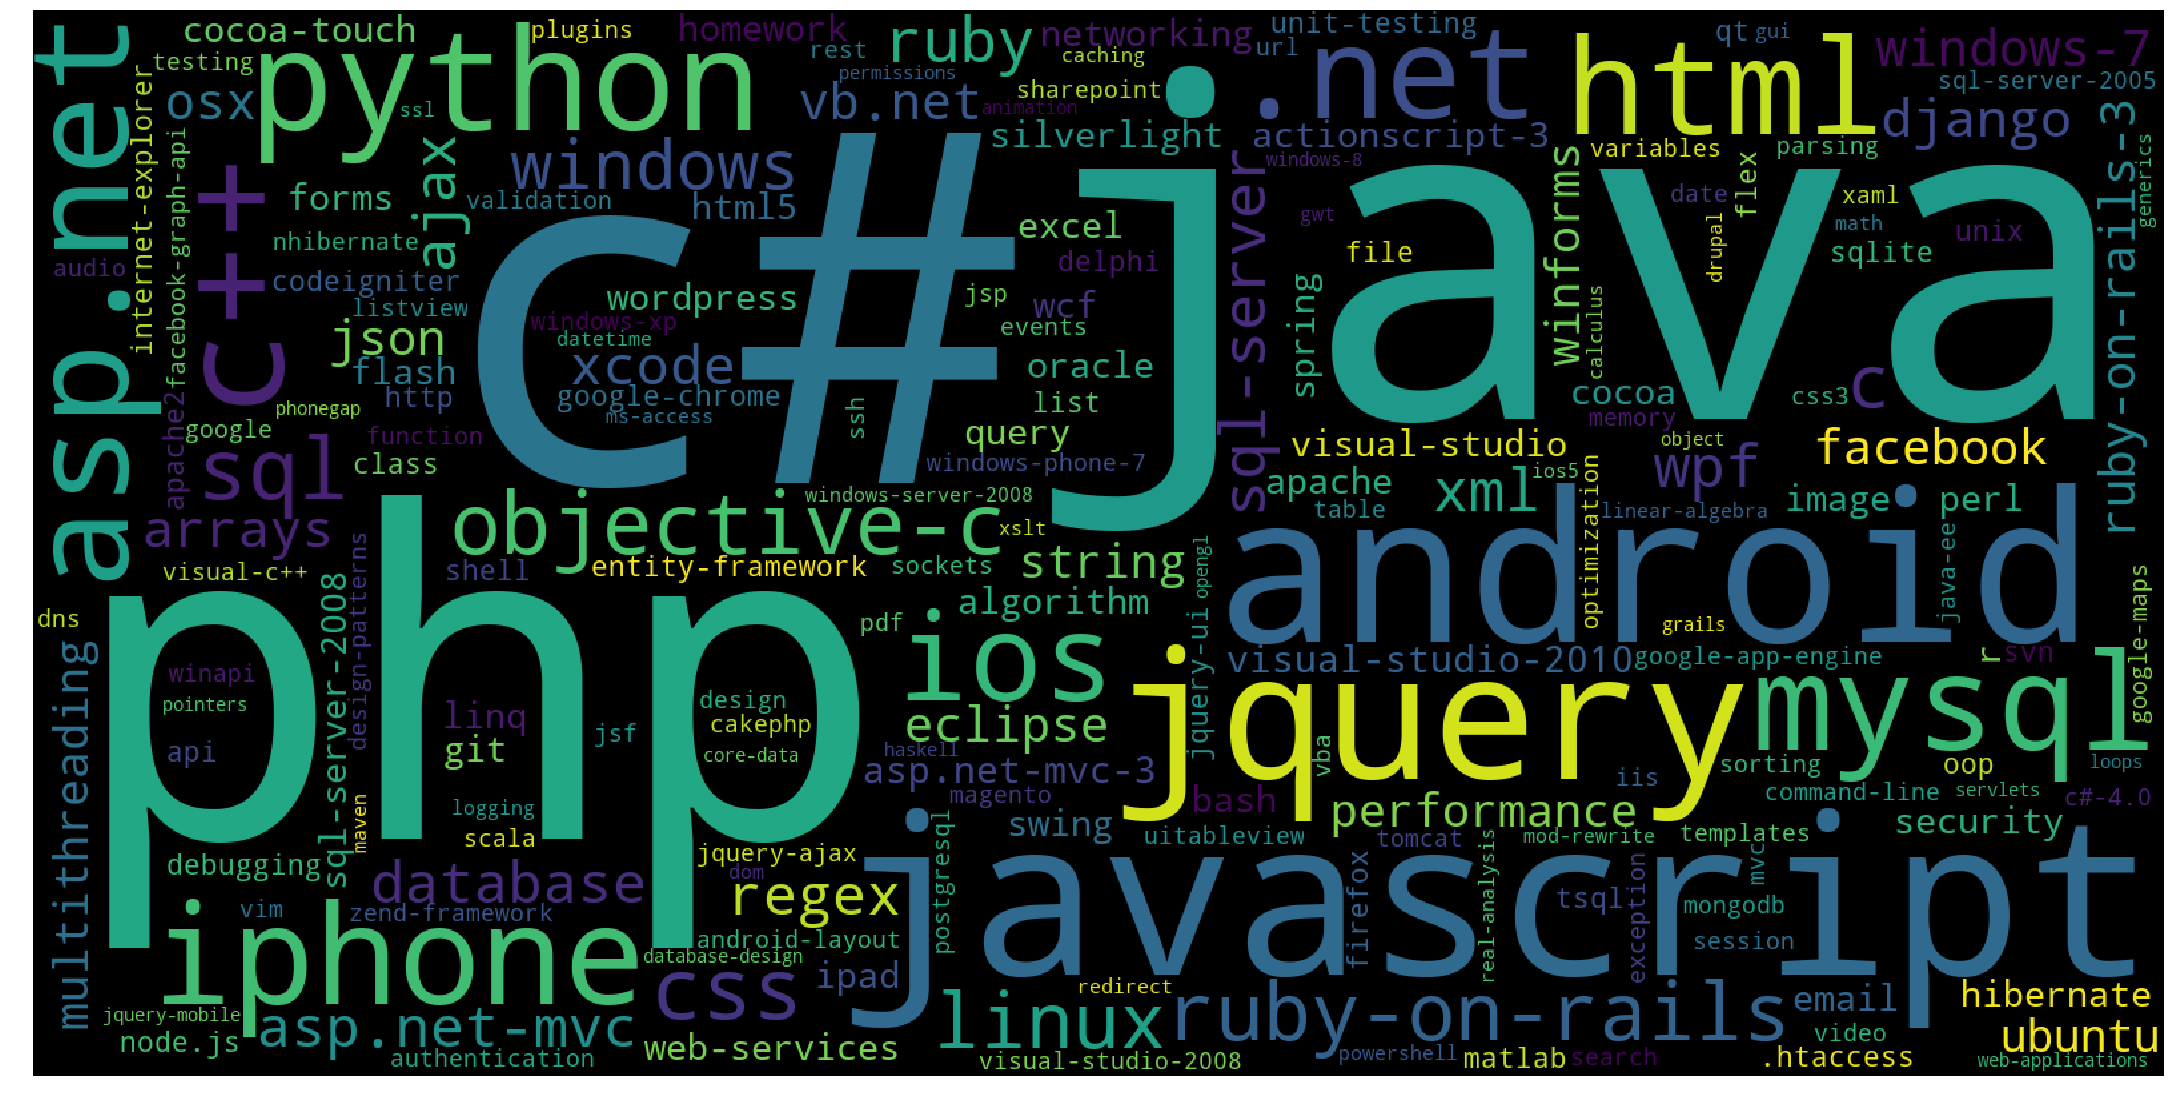

Time taken to run this cell : 0:00:03.902427


In [53]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

### The top 20 tags 

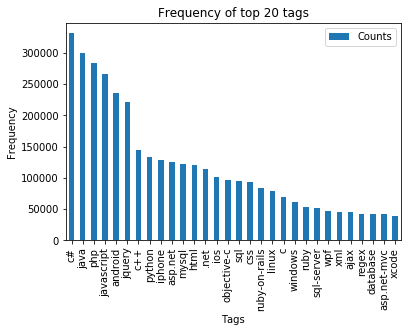

In [56]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

## Cleaning and preprocessing of Questions

### Preprocessing

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [59]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [60]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [61]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:08:47.628584


__ we create a new data base to store the sampled and preprocessed questions __

In [63]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1169
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57
Time taken to run this cell : 0:40:20.257613


In [66]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

ProgrammingError: Cannot operate on a closed database.

In [67]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('split text file got error compil wrong code error messag nproject project exe rais except class eaccessviol messag borland c',)
----------------------------------------------------------------------------------------------------
('wordpress imag fail plugin problem insert pictur post page work plugin use integr imag upload media librari pictur upload put post page display either workarea final post plugin deactiv imag opload work fine reaction follow file understand could',)
----------------------------------------------------------------------------------------------------
('blackberri jde blackberri jde releas beta version',)
----------------------------------------------------------------------------------------------------
('order display bindingresult error accord order field page use hibern implement jsr server side valid return immedi add error display page display error tag one locat error display page random order way coax spring display error ac

In [68]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [69]:
preprocessed_data.head()

,question,tags
0,issu chang button valu dynam wpf design like r...,c# .net wpf button
1,split text file got error compil wrong code er...,c
2,wordpress imag fail plugin problem insert pict...,image wordpress disabled
3,blackberri jde blackberri jde releas beta version,blackberry version beta jde
4,order display bindingresult error accord order...,java hibernate spring bean-validation


In [70]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999997
number of dimensions : 2


# Machine Learning Models 

## Converting tags for multilabel problems 

In [71]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [72]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [73]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

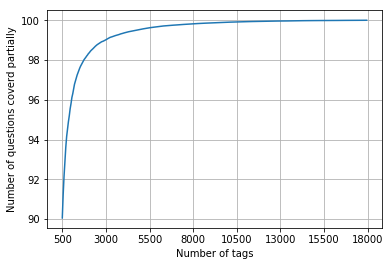

5500 tags cover  99.018 % of questions


In [74]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print(5500,"tags cover",questions_explained[50],"% of questions")

In [75]:
multilabel_yx = tags_to_choose(5500)
print("number of questions not covered:", questions_explained_fn(5500),"total: ", total_qs)

number of questions not covered: 9816 total:  999997


In [76]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35422
number of tags taken : 5500 ( 15.527073570097679 %)


__ We consider top 15% tags which covers  99% of the questions __

## Split the data into test and train (80:20) 

In [77]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [78]:
print("train data :", y_train.shape)
print("test data :", y_test.shape)

train data : (799997, 5500)
test data : (200000, 5500)


## Featurizing data

In [79]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:14:24.007714


In [80]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799997, 88268) Y : (799997, 5500)
Dimensions of test data X: (200000, 88268) Y: (200000, 5500)


## Applying Logistic Regression with OneVsRest Classifier 

In [ ]:
'''# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))'''

In [ ]:
'''from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl') '''

# Modeling with less data points (0.5M data points) and more weight to title and 500 tags only.

In [81]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [82]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


##  Preprocessing of questions

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [87]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title five time to the data to increase its weight
    # add tags string to the training data
    
    question=(str(title)+" ")*5+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 497
Percent of questions containing code: 57
Time taken to run this cell : 0:30:20.082574


In [88]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

### Sample quesitons after preprocessing of data

In [89]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri 

__ Saving Preprocessed data to a Database __

In [ ]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:
preprocessed_data.head()

In [ ]:
preprocessed_data

In [92]:
print("number of data points sampled :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points sampled : 500000
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [ ]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [100]:
#questions_explained

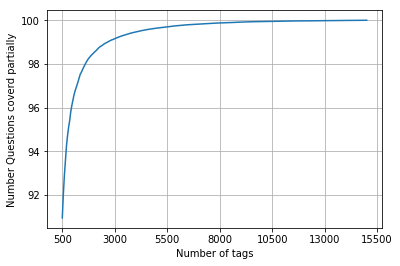

5500 tags covered 99.157 % of questions
500 tags covered 90.956 % of questions


In [95]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print(5500,"tags covered",questions_explained[50],"% of questions")
print(500,"tags covered",questions_explained[0],"% of questions")

In [ ]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions not covered: ", questions_explained_fn(500),"total: ", total_qs)

In [ ]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [106]:
x_train

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk
5,btnadd click event open two window record ad b...,javascript asp.net web
6,sql inject issu prevent correct form submiss p...,php forms
7,countabl subaddit lebesgu measur countabl suba...,real-analysis measure-theory
8,hql equival sql queri hql equival sql queri hq...,hibernate hql
9,undefin symbol architectur i386 objc class skp...,iphone email-integration


In [98]:
print("train data :", y_train.shape)
print("test data :", y_test.shape)

train data : (400000, 500)
test data : (100000, 500)


## Featurizing data with TfIdf vectorizer 

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

In [102]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (100000, 500)


## Applying Logistic Regression with OneVsRest Classifier

In [103]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

C:\Users\anich\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\anich\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\anich\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\anich\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the execut

Accuracy : 0.24732
Micro-average quality numbers
Precision: 0.7182, Recall: 0.3535, F1-measure: 0.4738


C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro-average quality numbers
Precision: 0.5581, Recall: 0.2855, F1-measure: 0.3627
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      5519
           1       0.69      0.31      0.43      8190
           2       0.80      0.40      0.53      6529
           3       0.82      0.46      0.59      3231
           4       0.80      0.42      0.55      6430
           5       0.82      0.37      0.51      2879
           6       0.87      0.51      0.64      5086
           7       0.88      0.55      0.68      4533
           8       0.61      0.13      0.21      3000
           9       0.82      0.55      0.66      2765
          10       0.61      0.20      0.30      3051
          11       0.66      0.37      0.47      3009
          12       0.61      0.28      0.39      2630
          13       0.73      0.29      0.41      1426
          14       0.89      0.56      0.69      2548
          15       0.65      0.21      0.32      23

C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [109]:
from sklearn.externals import joblib
joblib.dump(classifier_2, 'lr_with_5_more_title_weight.pkl') 

['lr_with_5_more_title_weight.pkl']

In [110]:
'''

trn_labels = trn_df['labels'].tolist()

# Define a LR classifier
classifier = LogisticRegression(solver="liblinear", multi_class="auto")
tuned_parameters = [{'C': [10**-2, 0.05, 10**-1, 0.5, 10**0]}]

clf = GridSearchCV(OneVsRestClassifier(SVC()),params, cv = 5)
#Using GridSearchCV
model = GridSearchCV(classifier, tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(trn_data, trn_labels)

print(model.best_estimator_)
#classifier.fit(trn_data, trn_labels)

# Measure the performance on training and dev data
print("Training accuracy = %f" % model.score(trn_data, trn_labels))
print("Dev accuracy = %f", model.score(dev_data, dev_labels))'''

'\n\ntrn_labels = trn_df[\'labels\'].tolist()\n\n# Define a LR classifier\nclassifier = LogisticRegression(solver="liblinear", multi_class="auto")\ntuned_parameters = [{\'C\': [10**-2, 0.05, 10**-1, 0.5, 10**0]}]\n\nclf = GridSearchCV(OneVsRestClassifier(SVC()),params, cv = 5)\n#Using GridSearchCV\nmodel = GridSearchCV(classifier, tuned_parameters, scoring = \'accuracy\', cv=5)\nmodel.fit(trn_data, trn_labels)\n\nprint(model.best_estimator_)\n#classifier.fit(trn_data, trn_labels)\n\n# Measure the performance on training and dev data\nprint("Training accuracy = %f" % model.score(trn_data, trn_labels))\nprint("Dev accuracy = %f", model.score(dev_data, dev_labels))'

In [119]:
from sklearn.model_selection import GridSearchCV

start = datetime.now()
params = [{'estimator__C': [0.1, 0.01, 0.001, 0.0001]}] #default is 1.
classifer_grid = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
clf = GridSearchCV(classifer_grid, params, scoring = 'f1_micro', cv=2)
clf.fit(x_train_multilabel[:100000,:], y_train[:100000,:])
print(model.best_estimator_)
print("Time taken to run this cell :", datetime.now() - start)

C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: Us

NameError: name 'model' is not defined

In [120]:
print(clf.best_estimator_)

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)


In [121]:
joblib.dump(clf, 'grid_search_best.pkl') 

['grid_search_best.pkl']

In [123]:

predictions_clf = clf.predict(x_test_multilabel[:5000,:])
print("Accuracy :",metrics.accuracy_score(y_test[:5000, :], predictions_clf))


precision = precision_score(y_test[:5000, :], predictions_clf, average='micro')
recall = recall_score(y_test[:5000, :], predictions_clf, average='micro')
f1 = f1_score(y_test[:5000, :], predictions_clf, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test[:5000, :], predictions_clf, average='macro')
recall = recall_score(y_test[:5000, :], predictions_clf, average='macro')
f1 = f1_score(y_test[:5000, :], predictions_clf, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test[:5000, :], predictions_clf))

Accuracy : 0.154
Micro-average quality numbers
Precision: 0.8035, Recall: 0.2658, F1-measure: 0.3994
Macro-average quality numbers
Precision: 0.2561, Recall: 0.1037, F1-measure: 0.1349
              precision    recall  f1-score   support

           0       0.96      0.32      0.48       355
           1       0.62      0.11      0.18       626
           2       0.81      0.40      0.54       593
           3       0.76      0.34      0.47       400
           4       0.89      0.62      0.73       676
           5       0.84      0.29      0.43       281
           6       0.92      0.60      0.73       362
           7       0.87      0.63      0.73       348
           8       0.55      0.14      0.23       191
           9       0.55      0.32      0.40        19
          10       0.33      0.04      0.06       114
          11       0.93      0.14      0.25       180
          12       0.59      0.07      0.13       139
          13       0.33      0.03      0.06       131
    

C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\anich\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Un